# 分类

## MNIST
下载数据

In [1]:
# from sklearn.datasets import fetch_openml

# mnist = fetch_openml('mnist_784', version=1, cache=True)
# print(mnist['DESCR'])

# X, y = mnist['data'], mnist['target']
# print(X.shape)
# print(y.shape)

from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)


展示一个数字和它的标签

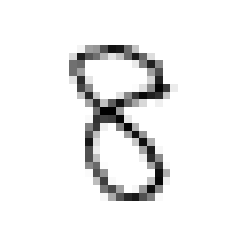

8


In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

some_digit = X_train[3600]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

print(y_train[3600])

划分训练集和测试集

In [3]:
# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二元分类器

In [4]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

# 训练
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# 测试
sgd_clf.predict([some_digit])


array([False])

## 性能考核

### 使用交叉验证测量精度

In [5]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9481 , 0.96245, 0.9694 ])

In [7]:
# 蠢笨的分类器
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90975, 0.90925, 0.90995])

因为只有大约10%的图像是数字5，所以如果你猜一张图不是5，90%的机会你都是正确的！

这说明准确率通常无法成为分类器的首要性能指标，特别是当你处理偏斜数据集的时候。

### 混淆矩阵

In [8]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52991,  1588],
       [  813,  4608]])

混淆矩阵能提供大量信息，但有时你可能希望指标更简洁一些。正类预测的准确率是一个有意思的指标，它也称为分类器的精度：
$$
精度 = \frac TP {TP + FP}
$$
TP是真正类的数量，FP是假正类的数量。

精度通常与另一个指标召回率（也称为灵敏度或正类率）一起使用。
$$
召回率 = \frac TP {TP + FN}
$$
FN是假负类的数量。

### 精度和召回率

In [12]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 4344 / (4344 + 1307)

0.7437056165267915

In [13]:
recall_score(y_train_5, y_train_pred)  # == 4344 / (4344 + 1077)

0.8500276701715551

我们可以很方便的将精度和召回率组合成一个单一的指标，称为$F_1$分数。当你需要一个简单的方法来比较两种分类器时，这是个非常不错的指标。

$F_1$分数是精度和召回率的谐波平均值。正常的平均值平等对待所有的值，而谐波平均值会给予较低的值更高的权重。因此，只有当召回率和精度都很高时，分类器才能得到较高的$F_1$分数。
$$
F_1 = \frac 2 {\frac 1 精度 + \frac 1 召回率} = 2 \times \frac {精度 \times 召回率} {精度 + 召回率} = \frac TP {TP + \frac {FN + FP} 2}
$$

$F_1$分数对具有相近的精度和召回率的分类器更为有利。
遗憾的是，不能同时增加精度和召回率，这称为*精度/召回率权衡*。


In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)


0.7933201342859602

### 精度/召回率权衡

In [16]:
# 获取分数
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# 提高阈值
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)


[-3985.45703312]
[False]
[False]


如何决定使用什么阈值呢？

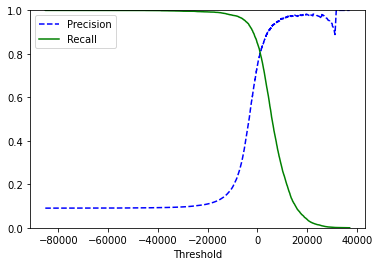

In [18]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# 绘图
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


还有一种找到好的精度/召回率权衡的方法是直接绘制精度和召回率的函数图

Text(0, 0.5, 'Precision')

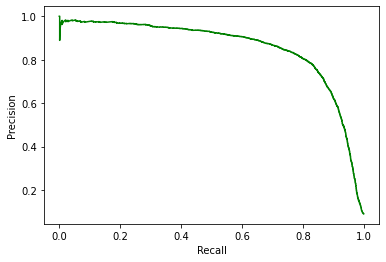

In [19]:
plt.plot(recalls[:-1], precisions[:-1], "g-")
plt.xlabel('Recall')
plt.ylabel('Precision')

### ROC曲线

还有一种经常和二元分类器一起使用的工具，叫*受试者工作特征曲线*(简称ROC)。它绘制的是真正类率（召回率的别名）和假正类率（FPR）。FPR是被错误分为正类的负类实例比例。

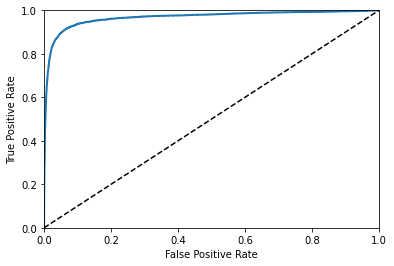

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()


有一种比较分类器的方法是测量曲线下面积(AUC)。完美的分类器的ROC AUC等于1，而纯随机分类器的ROC AUC等于0.5。

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9673027215053617

如何决定使用哪种曲线？
有一个经验法则是，当正类非常少见或者更关注假正类而不是假负类时，应该选择PR曲线，反之则时ROC曲线。

训练一个RandomForestClassifier分类器，并比较它和SGDClassifier分类器的ROC曲线和ROC AUC分数。

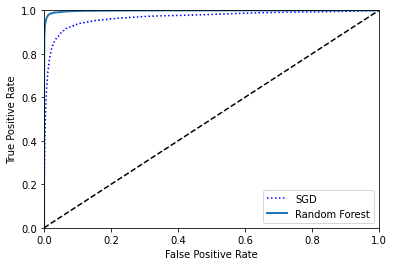

0.9983854326379538

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

# AUC
roc_auc_score(y_train_5, y_scores_forest)

## 多类别分类器

有一些算法（如随机森林分类器或朴素贝叶斯分类器）可以直接处理多个类别。也有一些严格的二元分类器（如支持向量机分类器或线性分类器）。但是，有多种策略可以让你用几个二元分类器实现多类别分类的目的。

一对多（OvA）策略：对n个类别训练n个分类器，决策时选择分数最高的分类器的类别作为分的类别。
一对一（OvO）策略：对n个类别训练n*（n-1）/2个分类器，每两个类别一个，决策时看哪个类别获胜最多。

Scikit-Learn可以检测到你尝试使用二元分类算法进行多类别分类任务，它会自动运行OvA（SVM除外）。

In [26]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([8], dtype=uint8)

In [29]:
# 查看所有类别的分数
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

max_index = np.argmax(some_digit_scores)
print(max_index)

print(sgd_clf.classes_)
print(sgd_clf.classes_[8])

[[-22927.45544723 -27151.35074199  -3759.96323068  -1243.69173378
   -6569.67092639  -5010.23186951 -11215.04648603 -10378.56073
     513.75483041  -4326.92274213]]
8
[0 1 2 3 4 5 6 7 8 9]
8


也可以强制使用一对一或一对多策略。

In [31]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([8], dtype=uint8)

In [32]:
len(ovo_clf.estimators_)

45

训练RandomForestClassifier同样简单。

In [33]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([8], dtype=uint8)

In [35]:
# 获取所有概率
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.01, 0.1 , 0.02, 0.06, 0.  , 0.  , 0.78, 0.02]])

In [36]:
# 交叉验证
cross_val_score(sgd_clf, X_train ,y_train, cv=3, scoring='accuracy')

array([0.8844 , 0.88165, 0.87705])

还可以进一步提高

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90325, 0.9057 , 0.89965])

## 错误分析

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[[5612    0   17    7    9   43   32    5  197    1]
 [   0 6413   46   23    4   40    5    8  190   13]
 [  28   28 5281   95   69   20   67   34  323   13]
 [  27   22  114 5288    1  196   24   42  343   74]
 [  11   16   44   13 5242    9   38   24  276  169]
 [  26   17   32  159   48 4496   77   18  473   75]
 [  30   15   48    2   46   95 5559    4  119    0]
 [  19   15   56   27   51    8    6 5717  149  217]
 [  20   69   43  103    2  131   30    7 5399   47]
 [  22   25   30   64  125   43    1  178  296 5165]]


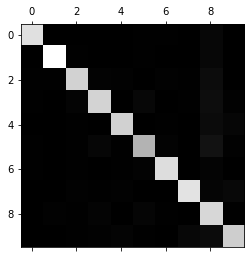

In [38]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

让我们把焦点放在错误上。首先，你需要将混淆矩阵中的每个值除以相应类别中的图片数量，这样你比较的就是错误率而不是错误的绝对值（后者对图片数量较多的类别不公平）：

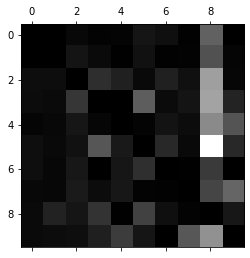

In [39]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# 用零填充对角线，只保留错误
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


分析单个的错误也可以为分类器提供洞察，这里看数字3和数字5的例子。

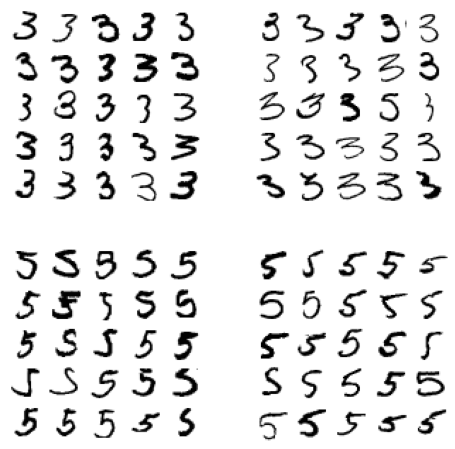

In [43]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 多标签分类

In [44]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[ True, False]])

评估多标签分类器的方法很多，如何选择正确的度量指标取决于你的项目。比如方法之一是测量每个标签的$F_1$分数，然后简单的平均。

In [46]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average='macro')

0.9678571713622114

也可以为每个标签设置一个等于自身支持的权重。

In [47]:
f1_score(y_train, y_train_knn_pred, average='weighted')

0.9680017543259757

## 多输出分类

多输出-多类别分类（简称多输出分类）是多标签分类的泛化，其标签也可以是多种类别的。
这里构建一个系统去除图片中的噪声。这个分类器的输出是多个标签（一个像素点一个标签），每个标签可以有多个值（0到255）。

In [48]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

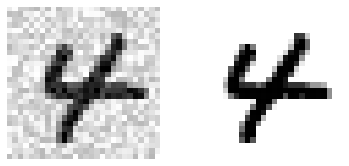

In [50]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")


some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

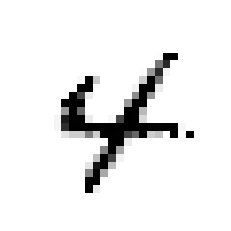

In [51]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)